# Data Generation

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [ ]:
# Parameters
start_date = datetime(2021, 1, 1)
end_date = start_date + timedelta(days=3*365)  # Approximately 3 years
date_range = pd.date_range(start_date, end_date, freq='D')

# Define Campaigns with their respective parameters
campaigns = {
    'Old_Campaign': {
        'visitor_lam': 1200,          # Average visitors per day
        'conversion_rate': 0.19,      # 19% conversion rate
        'avg_revenue': 15,            # Average revenue per conversion in $
        'revenue_variation': 2        # Standard deviation for revenue
    },
    'New_Campaign': {
        'visitor_lam': 1150,          # Slightly fewer visitors
        'conversion_rate': 0.23,      # Improved conversion rate at 23%
        'avg_revenue': 16,            # Slightly higher revenue per conversion
        'revenue_variation': 2        # Standard deviation for revenue
    }
}

# Initialize list to store data
data = []

# Set seed for reproducibility
np.random.seed(42)

# Generate data
for single_date in date_range:
    for campaign_name, params in campaigns.items():
        # Simulate Visitors using Poisson distribution
        visitors = np.random.poisson(lam=params['visitor_lam'])

        # Simulate Conversions using Binomial distribution
        conversions = np.random.binomial(n=visitors, p=params['conversion_rate'])

        # Simulate Revenue with some variation
        avg_revenue_per_conversion = params['avg_revenue'] + np.random.normal(0, params['revenue_variation'])
        revenue = conversions * avg_revenue_per_conversion

        # Append the record
        data.append({
            'Date': single_date.strftime('%Y-%m-%d'),
            'Campaign': campaign_name,
            'Visitors': visitors,
            'Conversions': conversions,
            'Revenue': round(revenue, 2)
        })

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()

,Date,Campaign,Visitors,Conversions,Revenue
0,2021-01-01,Old_Campaign,1187,216,3138.85
1,2021-01-01,New_Campaign,1160,241,3743.15
2,2021-01-02,Old_Campaign,1238,238,3685.17
3,2021-01-02,New_Campaign,1143,285,3469.43
4,2021-01-03,Old_Campaign,1178,222,3359.98


In [ ]:
# Save to CSV
df.to_csv('ab_testing_forecasting_dataset.csv', index=False)

print("Dataset generated and saved as 'ab_testing_forecasting_dataset.csv'")

Dataset generated and saved as 'ab_testing_forecasting_dataset.csv'


In [ ]:
from google.colab import files
files.download('ab_testing_forecasting_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Exploration

In [ ]:
# Load the dataset
df = pd.read_csv('ab_testing_forecasting_dataset.csv')

# Display first few rows
df.head()

,Date,Campaign,Visitors,Conversions,Revenue
0,2021-01-01,Old_Campaign,1187,216,3138.85
1,2021-01-01,New_Campaign,1160,241,3743.15
2,2021-01-02,Old_Campaign,1238,238,3685.17
3,2021-01-02,New_Campaign,1143,285,3469.43
4,2021-01-03,Old_Campaign,1178,222,3359.98


In [ ]:
# Summary statistics
df.describe()

,Visitors,Conversions,Revenue
count,2192.000000,2192.000000,2192.00000
mean,1174.634124,246.044708,3823.76875
std,42.884008,24.007412,683.48026
min,1051.000000,182.000000,1617.08000
25%,1145.000000,227.000000,3353.32750
50%,1173.000000,245.000000,3775.20500
75%,1204.000000,264.000000,4270.64000
max,1315.000000,316.000000,6302.65000


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Date,0
Campaign,0
Visitors,0
Conversions,0
Revenue,0


In [ ]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2192 non-null   object 
 1   Campaign     2192 non-null   object 
 2   Visitors     2192 non-null   int64  
 3   Conversions  2192 non-null   int64  
 4   Revenue      2192 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 85.8+ KB


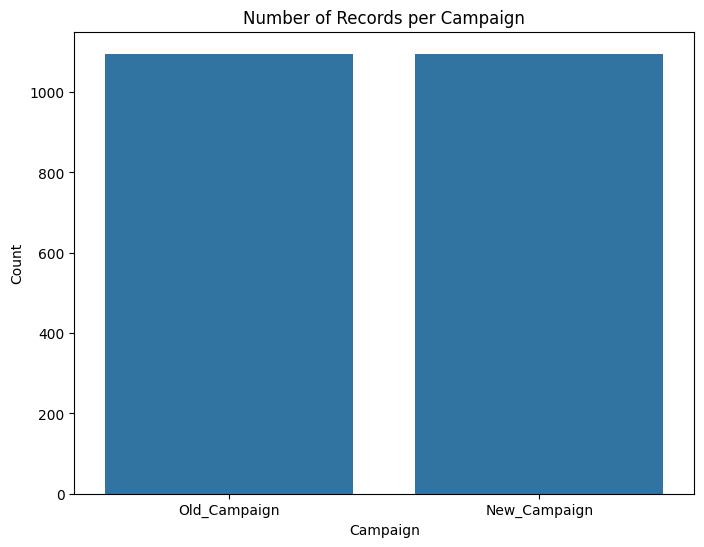

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot for Campaign
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Campaign')
plt.title('Number of Records per Campaign')
plt.xlabel('Campaign')
plt.ylabel('Count')
plt.show()

# AB Testing

In [ ]:
# Aggregate total conversions and visitors per campaign
summary = df.groupby('Campaign').agg(
    Total_Conversions=('Conversions', 'sum'),
    Total_Visitors=('Visitors', 'sum')
).reset_index()

# Calculate Total Failures
summary['Total_Failures'] = summary['Total_Visitors'] - summary['Total_Conversions']

# Display summary
summary

,Campaign,Total_Conversions,Total_Visitors,Total_Failures
0,New_Campaign,289624,1260344,970720
1,Old_Campaign,249706,1314454,1064748


In [ ]:
# Create contingency table
contingency = summary[['Total_Conversions', 'Total_Failures']].values

# Display contingency table
contingency_df = pd.DataFrame(contingency, index=summary['Campaign'], columns=['Conversions', 'Failures'])
print("Contingency Table:")
display(contingency_df)

Contingency Table:


,Conversions,Failures
Campaign,,
New_Campaign,289624,970720
Old_Campaign,249706,1064748


In [ ]:
from scipy.stats import chi2_contingency

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 6163.442893685703
P-Value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 263997.92508772  996346.07491228]
 [ 275332.07491228 1039121.92508772]]


In [ ]:
alpha = 0.05  # Significance level

if p < alpha:
    print(f"Since p-value ({p}) < {alpha}, we reject the null hypothesis.")
    print("There is a significant difference in conversion rates between the campaigns.")
else:
    print(f"Since p-value ({p}) >= {alpha}, we fail to reject the null hypothesis.")
    print("There is no significant difference in conversion rates between the campaigns.")

Since p-value (0.0) < 0.05, we reject the null hypothesis.
There is a significant difference in conversion rates between the campaigns.


# Forecasting

In [ ]:
from prophet import Prophet

def forecast_metric(df, campaign_name, metric, periods=30):
    """
    Forecast a specified metric for a given campaign.

    Parameters:
    - df: DataFrame containing the data
    - campaign_name: Name of the campaign (e.g., 'New_Campaign')
    - metric: Metric to forecast ('Visitors', 'Conversions', 'Revenue')
    - periods: Number of days to forecast into the future

    Returns:
    - forecast: DataFrame with forecasted values
    """
    # Filter data for the specified campaign
    campaign_data = df[df['Campaign'] == campaign_name]

    # Aggregate daily metric
    daily_metric = campaign_data.groupby('Date')[metric].sum().reset_index()
    daily_metric.rename(columns={'Date': 'ds', metric: 'y'}, inplace=True)

    # Convert 'ds' to datetime
    daily_metric['ds'] = pd.to_datetime(daily_metric['ds'])

    # Initialize Prophet model
    model = Prophet()
    model.fit(daily_metric)

    # Create future dataframe
    future = model.make_future_dataframe(periods=periods)

    # Make forecast
    forecast = model.predict(future)

    # Plot forecast
    fig1 = model.plot(forecast)
    plt.title(f'{campaign_name} {metric} Forecast')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.show()

    # Plot forecast components
    fig2 = model.plot_components(forecast)
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/t42crlso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/_6xplupu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54478', 'data', 'file=/tmp/tmp85mnvdsu/t42crlso.json', 'init=/tmp/tmp85mnvdsu/_6xplupu.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_modelu2tqauh0/prophet_model-20241107023113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


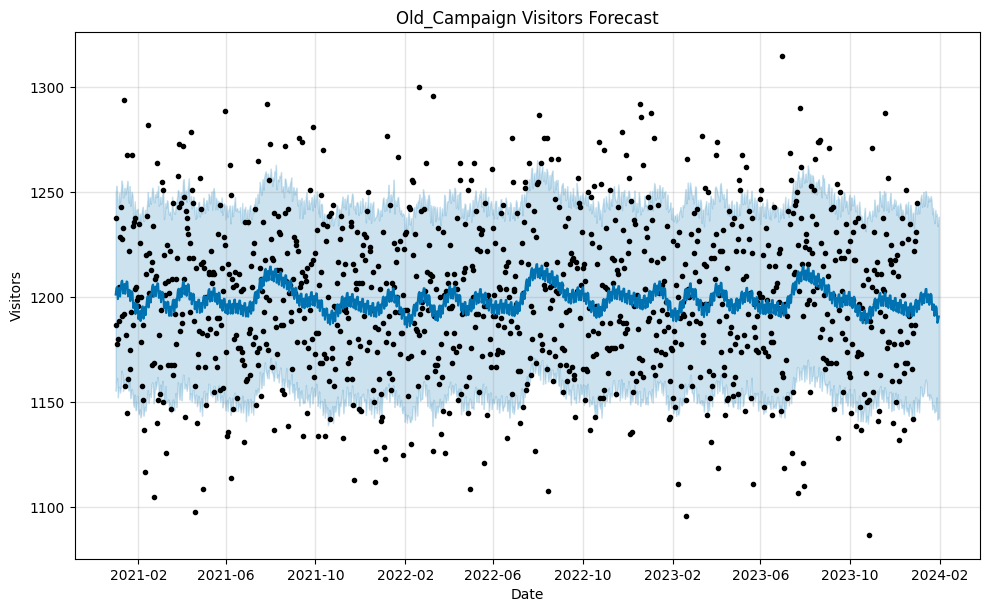

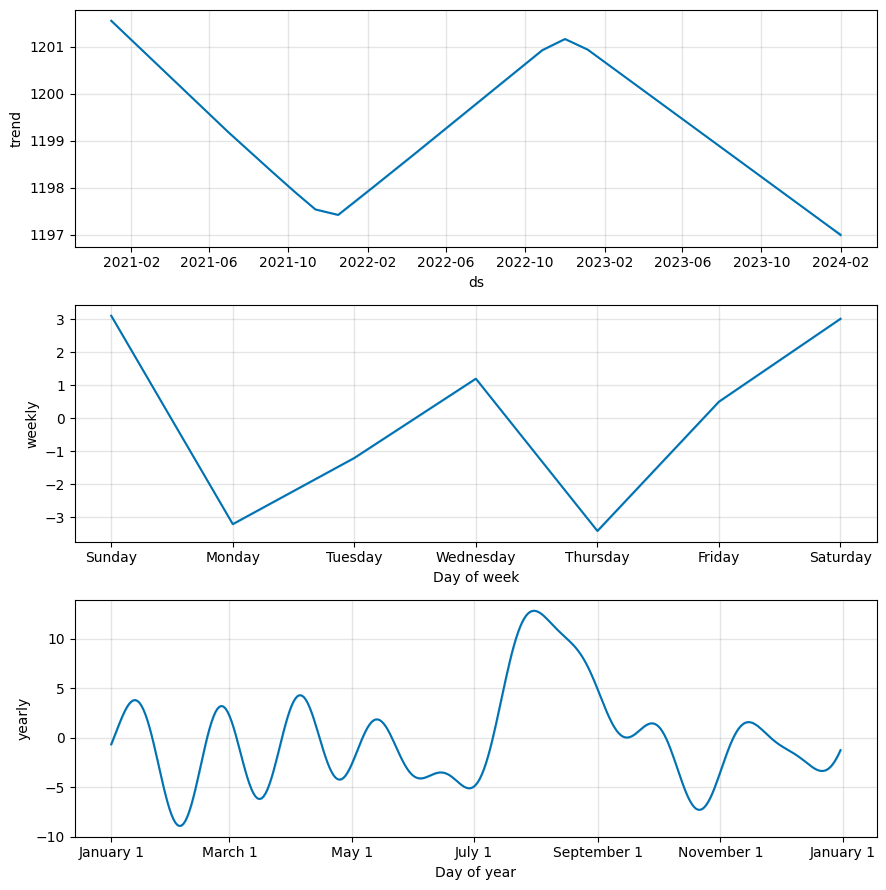

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/b5ahb183.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/pthruvl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20911', 'data', 'file=/tmp/tmp85mnvdsu/b5ahb183.json', 'init=/tmp/tmp85mnvdsu/pthruvl8.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_modelp0canaqx/prophet_model-20241107023122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


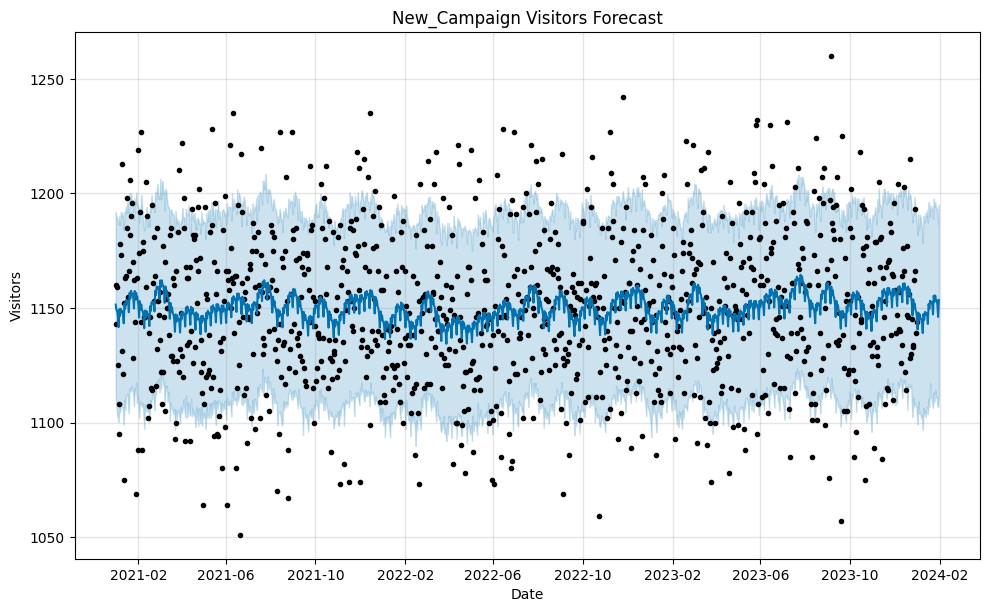

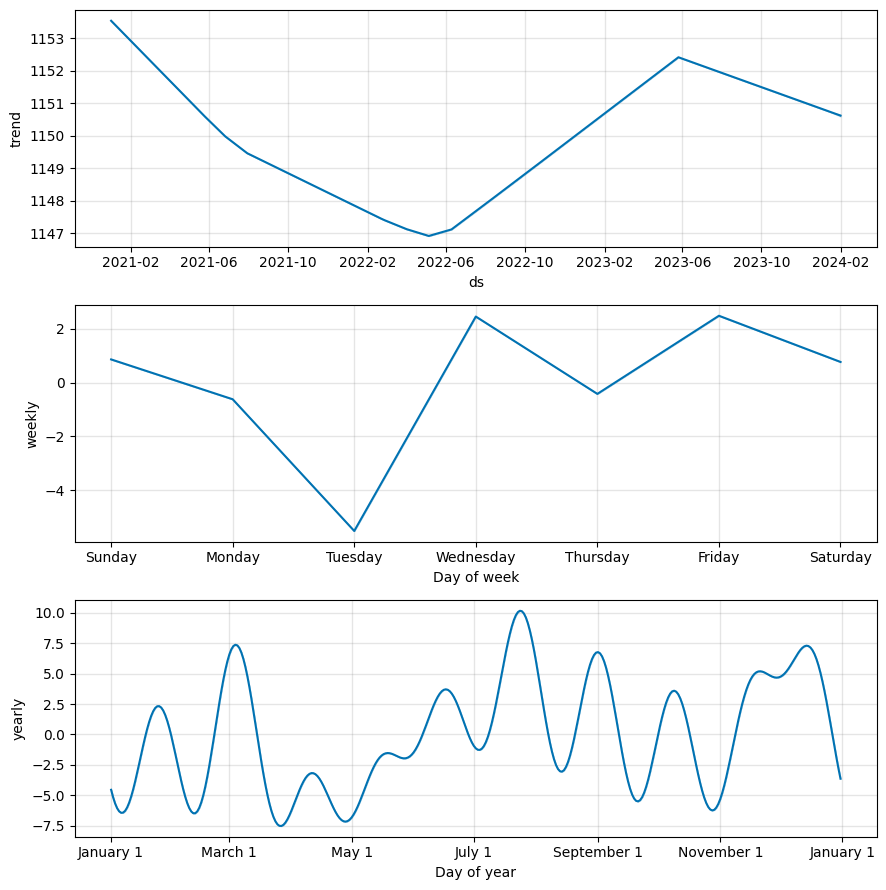

In [ ]:
# Forecast Visitors for Old_Campaign
forecast_old_visitors = forecast_metric(df, 'Old_Campaign', 'Visitors', periods=30)

# Forecast Visitors for New_Campaign
forecast_new_visitors = forecast_metric(df, 'New_Campaign', 'Visitors', periods=30)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/pjq2e67x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/avffsqfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74369', 'data', 'file=/tmp/tmp85mnvdsu/pjq2e67x.json', 'init=/tmp/tmp85mnvdsu/avffsqfi.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_modelwm0wgf_y/prophet_model-20241107023124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


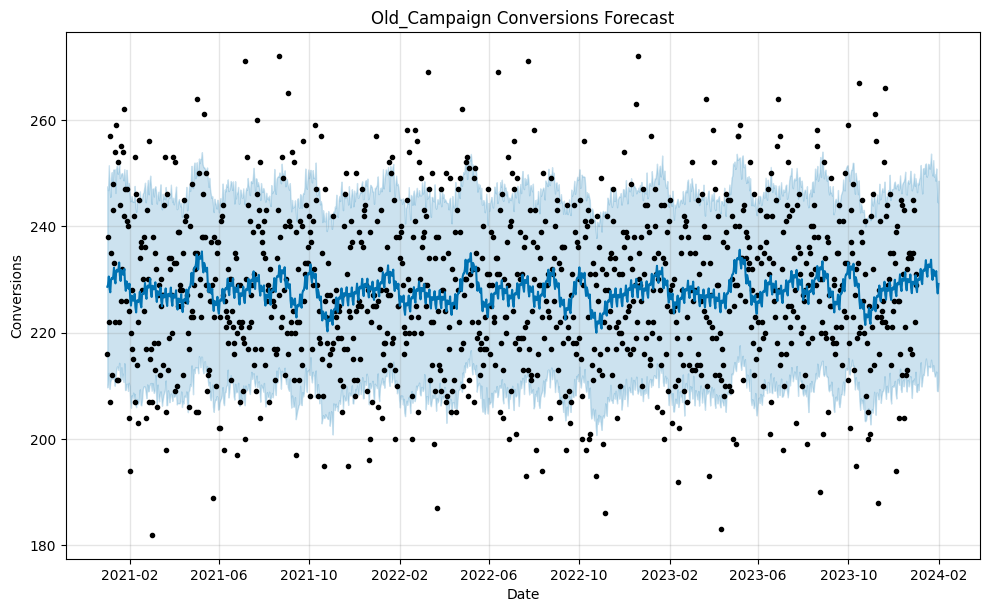

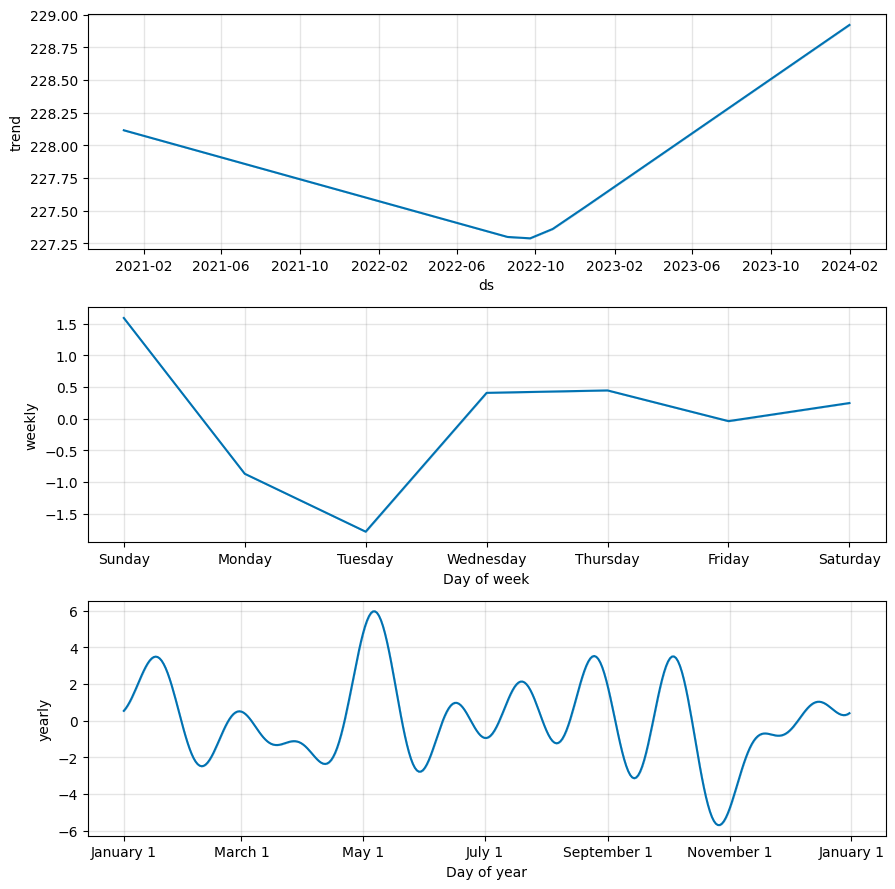

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/_ux97d5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/s182eyi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22693', 'data', 'file=/tmp/tmp85mnvdsu/_ux97d5k.json', 'init=/tmp/tmp85mnvdsu/s182eyi7.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_modelqwwwmn9h/prophet_model-20241107023126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


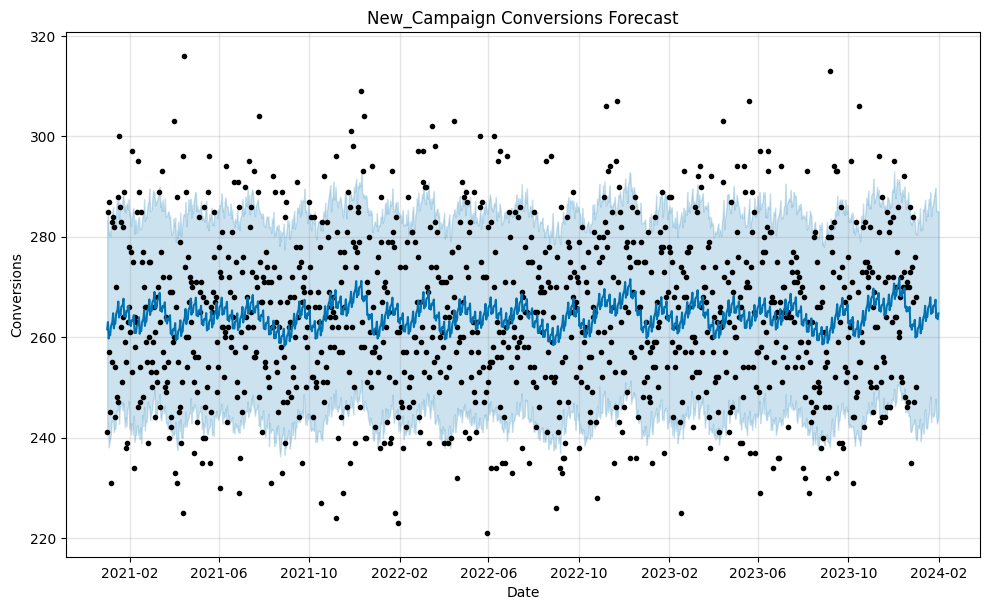

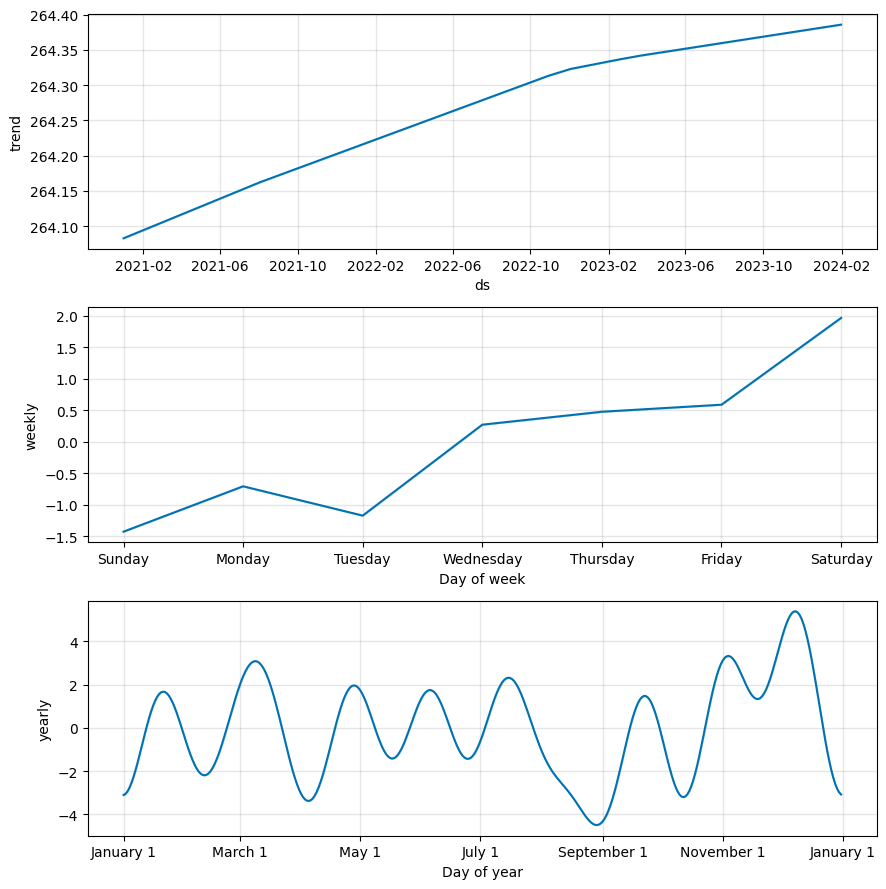

In [ ]:
# Forecast Conversions for Old_Campaign
forecast_old_conversions = forecast_metric(df, 'Old_Campaign', 'Conversions', periods=30)

# Forecast Conversions for New_Campaign
forecast_new_conversions = forecast_metric(df, 'New_Campaign', 'Conversions', periods=30)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/qz200gbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/4knkqtl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49856', 'data', 'file=/tmp/tmp85mnvdsu/qz200gbw.json', 'init=/tmp/tmp85mnvdsu/4knkqtl_.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_model_yao311a/prophet_model-20241107023128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


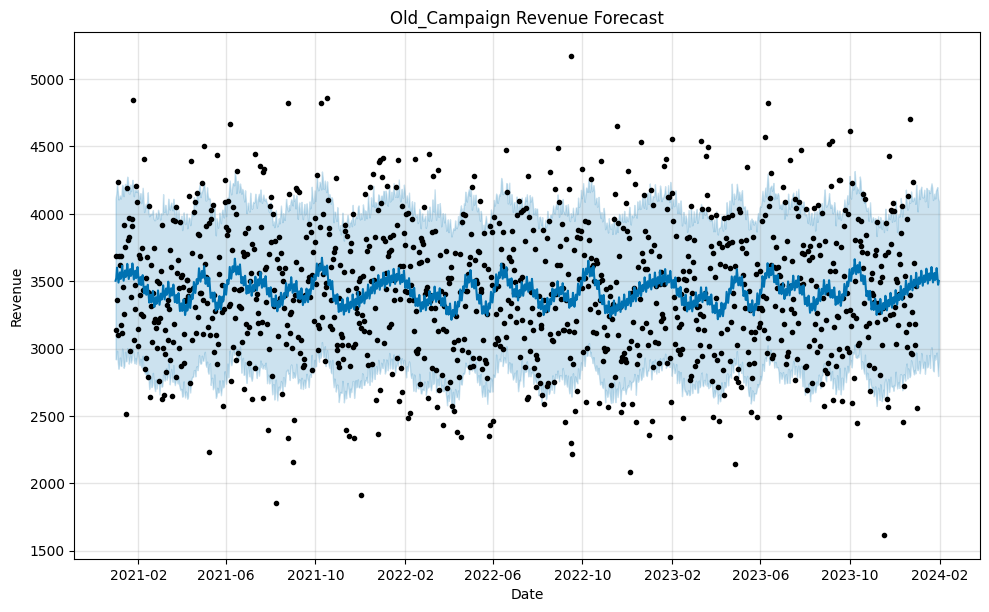

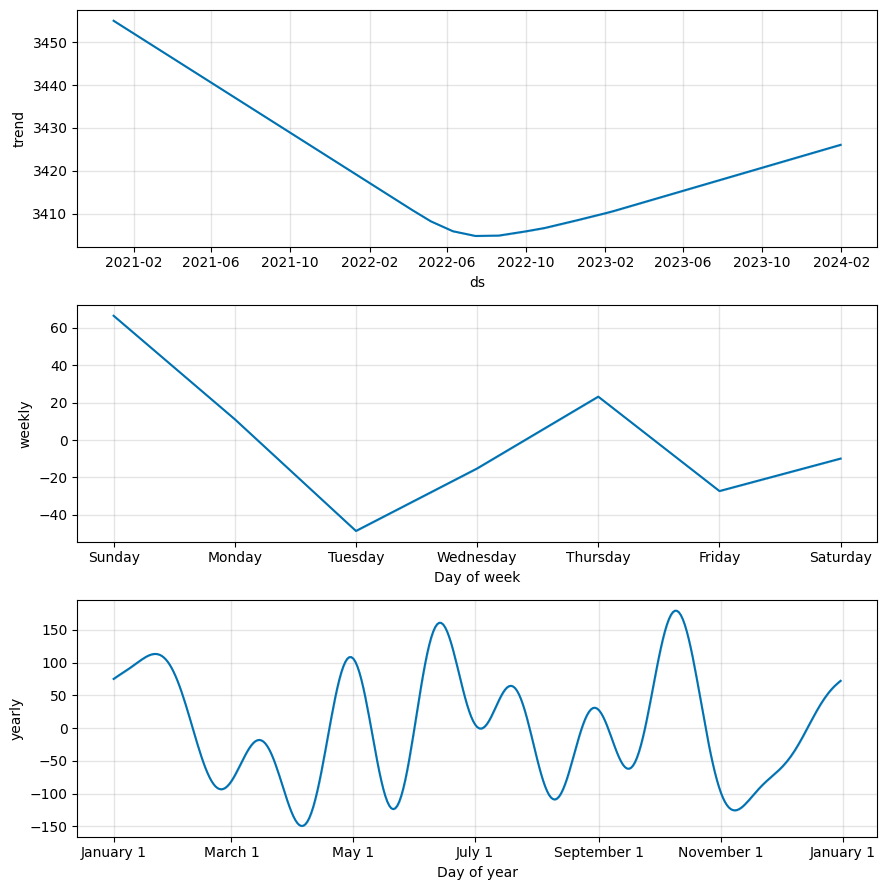

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/3nc57sa0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp85mnvdsu/52i_rdwr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20514', 'data', 'file=/tmp/tmp85mnvdsu/3nc57sa0.json', 'init=/tmp/tmp85mnvdsu/52i_rdwr.json', 'output', 'file=/tmp/tmp85mnvdsu/prophet_modelvt4m4449/prophet_model-20241107023129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


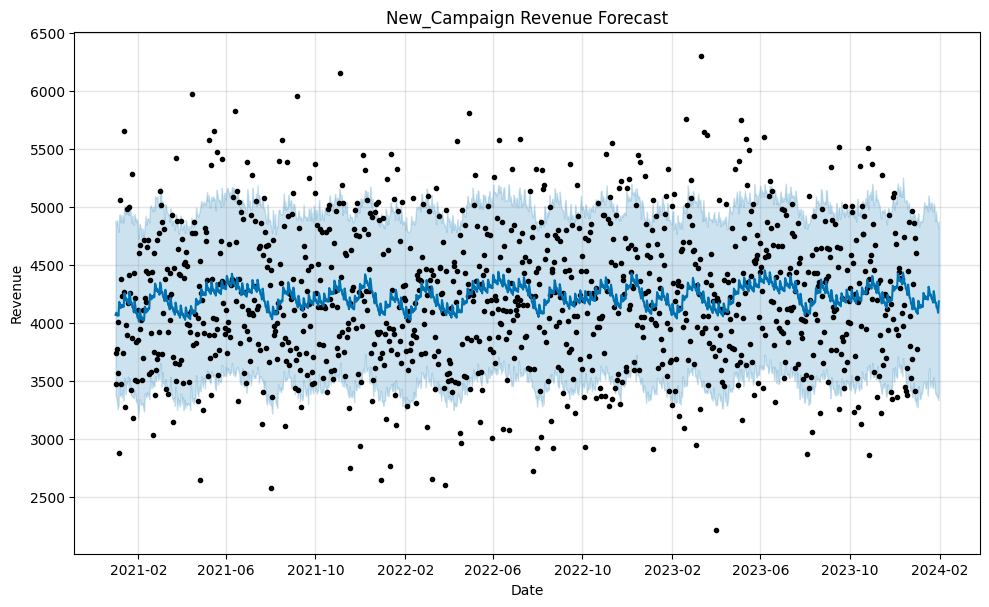

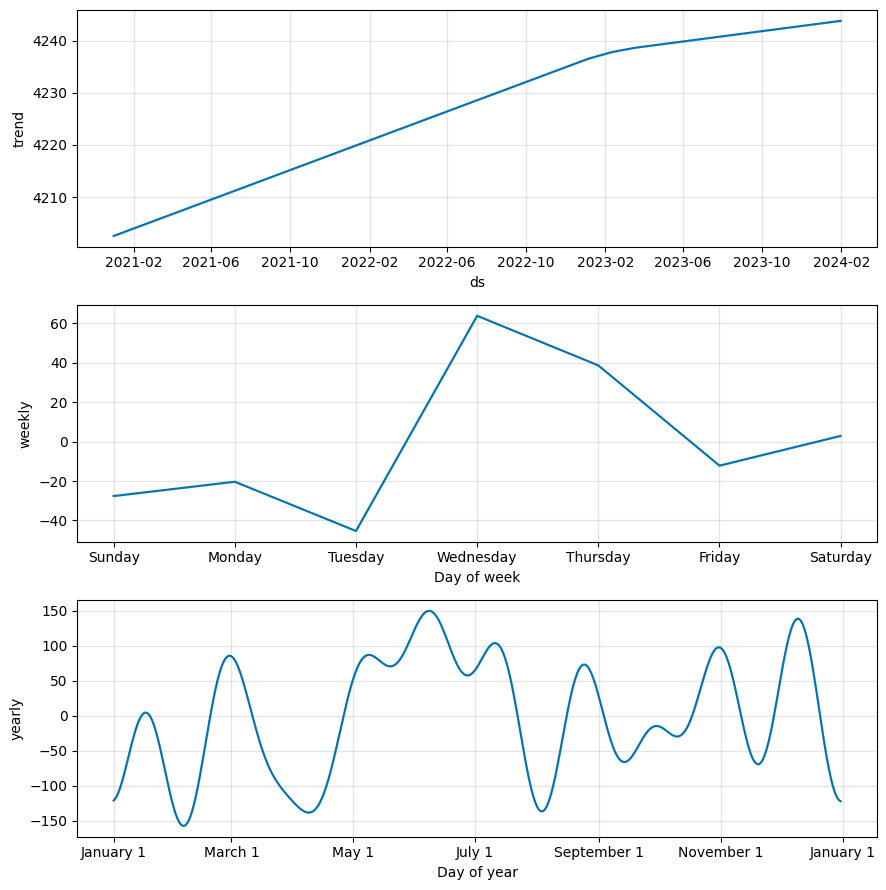

In [ ]:
# Forecast Revenue for Old_Campaign
forecast_old_revenue = forecast_metric(df, 'Old_Campaign', 'Revenue', periods=30)

# Forecast Revenue for New_Campaign
forecast_new_revenue = forecast_metric(df, 'New_Campaign', 'Revenue', periods=30)

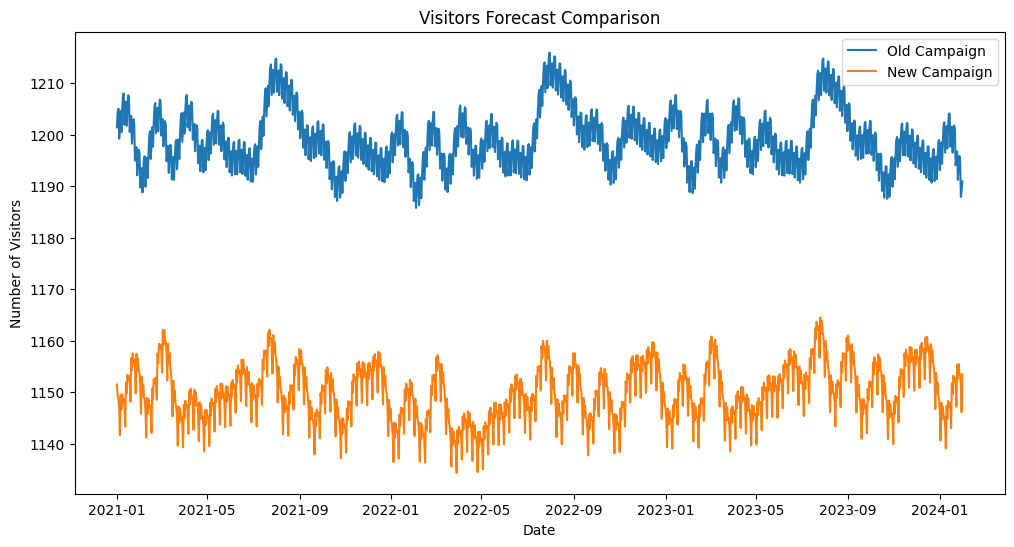

In [ ]:
# Merge forecasts for comparison
comparison_visitors = pd.DataFrame({
    'Date': forecast_old_visitors['ds'],
    'Old_Campaign_Predicted': forecast_old_visitors['yhat'],
    'New_Campaign_Predicted': forecast_new_visitors['yhat']
})

# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(comparison_visitors['Date'], comparison_visitors['Old_Campaign_Predicted'], label='Old Campaign')
plt.plot(comparison_visitors['Date'], comparison_visitors['New_Campaign_Predicted'], label='New Campaign')
plt.title('Visitors Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()